In [6]:
# Check if running in a Google Colab environment
try:
    import google.colab
    !pip install -Uqq fastbook
except ImportError:
    pass

import fastbook
fastbook.setup_book()


In [8]:
pip install pyarrow==15.0.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.1
    Uninstalling pyarrow-14.0.1:
      Successfully uninstalled pyarrow-14.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.0 which is incompatible.


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'c21787da9d6149e08ff84cac620b2a23')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

147

In [6]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [7]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

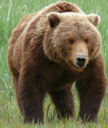

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [20]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [24]:
fns = get_image_files(path)
fns

(#372) [Path('bears/black/3a42efea-0320-4a28-9fc2-9c52b93db34d.jpg'),Path('bears/black/bc08e225-156a-48d3-95ae-eb1c99397f35.jpg'),Path('bears/black/38bb2e55-a006-461d-9611-7ec6b97f3a51.jpeg'),Path('bears/black/6700a9d2-d58c-49a5-b6af-b2785448bc53.jpg'),Path('bears/black/d47a7852-0661-40cb-9639-734ca5f892b7.jpg'),Path('bears/black/fb5bc736-1c9c-4cc6-bf33-cb16dc00a4d3.jpg'),Path('bears/black/c04bbdc4-1e3c-41a9-a048-485a3f1a7a31.jpg'),Path('bears/black/992c07e8-7b11-45c5-97e8-98e8279bcf98.jpg'),Path('bears/black/525ae32d-7cfb-4a62-8f11-7f8c09498444.jpg'),Path('bears/black/6d11c540-23bb-443d-9e67-327ba4a24080.jpg')...]

In [25]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [26]:
fns = get_image_files(path)
fns

(#372) [Path('bears/black/3a42efea-0320-4a28-9fc2-9c52b93db34d.jpg'),Path('bears/black/bc08e225-156a-48d3-95ae-eb1c99397f35.jpg'),Path('bears/black/38bb2e55-a006-461d-9611-7ec6b97f3a51.jpeg'),Path('bears/black/6700a9d2-d58c-49a5-b6af-b2785448bc53.jpg'),Path('bears/black/d47a7852-0661-40cb-9639-734ca5f892b7.jpg'),Path('bears/black/fb5bc736-1c9c-4cc6-bf33-cb16dc00a4d3.jpg'),Path('bears/black/c04bbdc4-1e3c-41a9-a048-485a3f1a7a31.jpg'),Path('bears/black/992c07e8-7b11-45c5-97e8-98e8279bcf98.jpg'),Path('bears/black/525ae32d-7cfb-4a62-8f11-7f8c09498444.jpg'),Path('bears/black/6d11c540-23bb-443d-9e67-327ba4a24080.jpg')...]

In [27]:
failed = verify_images(fns)
failed

(#0) []

In [28]:
failed.map(Path.unlink);

In [30]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [31]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [32]:
blocks=(ImageBlock, CategoryBlock)

In [33]:
get_items=get_image_files

In [34]:
splitter=RandomSplitter(valid_pct=0.2, seed=42)

In [35]:
get_y=parent_label

In [36]:
item_tfms=Resize(128)

In [37]:
dls = bears.dataloaders(path)

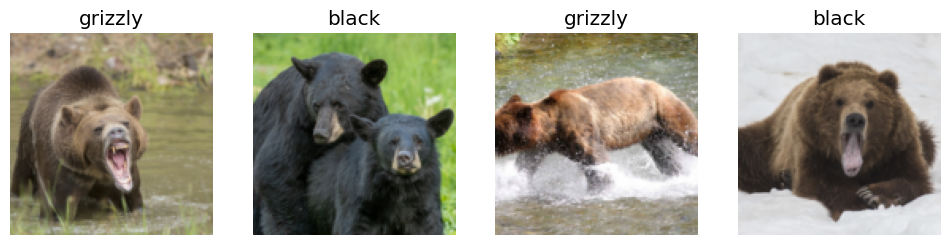

In [38]:
dls.valid.show_batch(max_n=4, nrows=1)

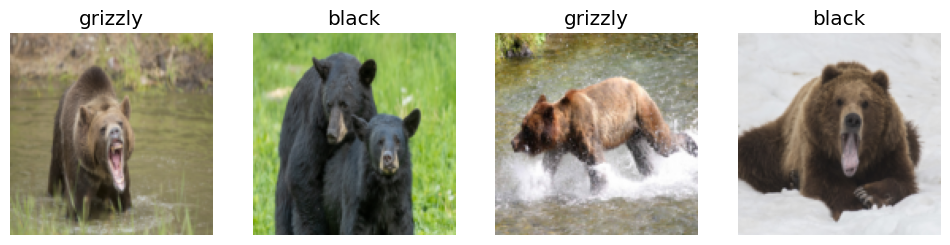

In [39]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

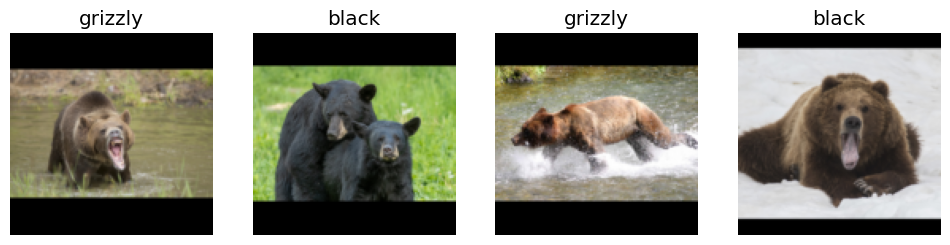

In [40]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

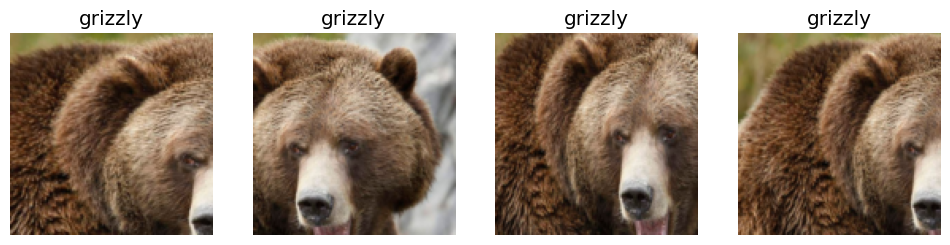

In [41]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

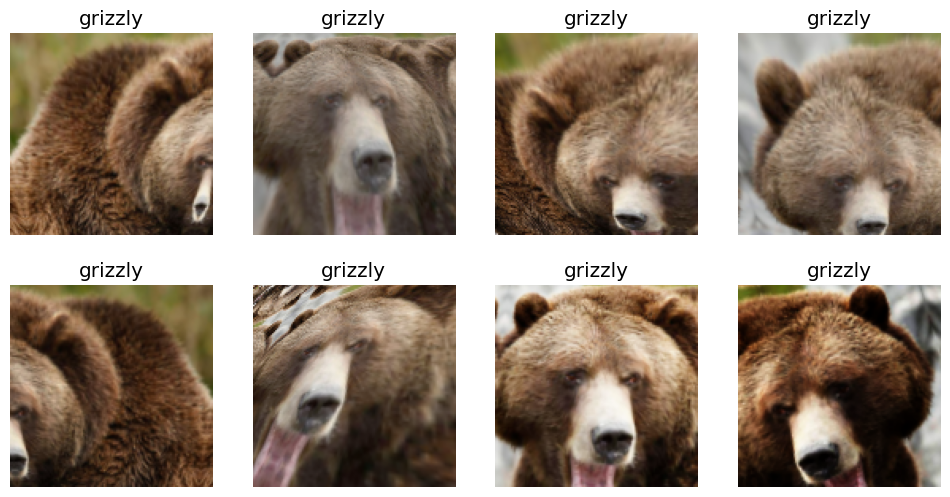

In [42]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [44]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [46]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


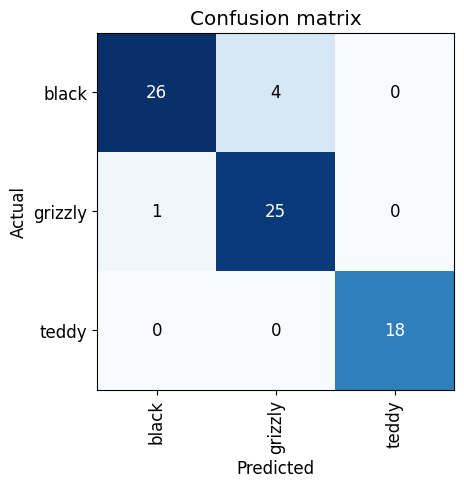

In [47]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

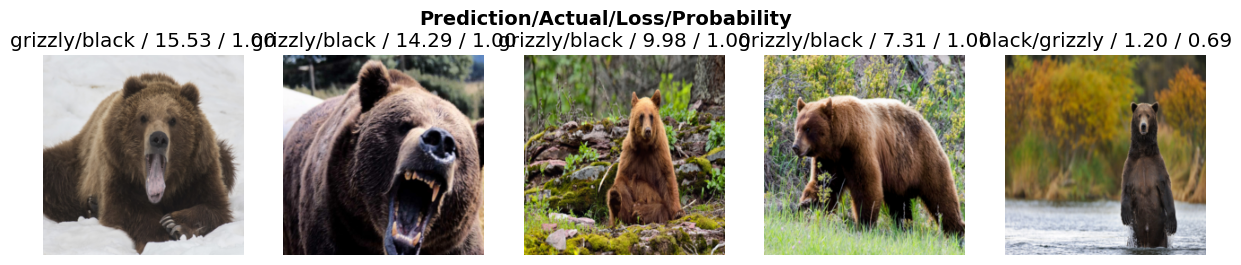

In [48]:
interp.plot_top_losses(5, nrows=1)

In [49]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [50]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [51]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [52]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [53]:
learn.export()

In [54]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [55]:
learn_inf = load_learner(path/'export.pkl')

In [56]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.0460e-05, 9.9999e-01, 9.0846e-08]))

In [57]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [58]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [59]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [60]:
img = PILImage.create(btn_upload.data[-1])

In [61]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [62]:
pred,pred_idx,probs = learn_inf.predict(img)

In [63]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [64]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [65]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [66]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [67]:
#hide_output
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

In [68]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila

In [69]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.3/157.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.24.0
    Uninstalling jupyter-server-1.24.0:
      Successfully uninstalled jupyter-server-1.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following